# Cable Equation
Author: Christian Pehle



In [1]:
import jax.numpy as np
import tree_math
import dataclasses

from njx.base import funcutils
from njx.base import implicit
from njx.base.tree_solver import tree_solve, tree_matmul
from njx.base.types import ArrayLike

import matplotlib.pyplot as plt

In [2]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-10 * state.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [3]:
N = 5
dt = 1e-2
inner_steps = 1
outer_steps = 2048
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d=-2 * np.ones(N), u=np.ones(N - 1), p=np.arange(-1, N, 1)
)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
    funcutils.repeated(semi_implicit_step, inner_steps), outer_steps
)

actual_v = []
for idx in range(N):
    initial_state = NeuronState(
        v=np.zeros(N), I=np.concatenate((np.eye(5)[idx], np.zeros(N - 5)))
    )
    _, actual = integrator(initial_state)
    actual_v.append(actual.v)

actual_v = np.stack(actual_v)

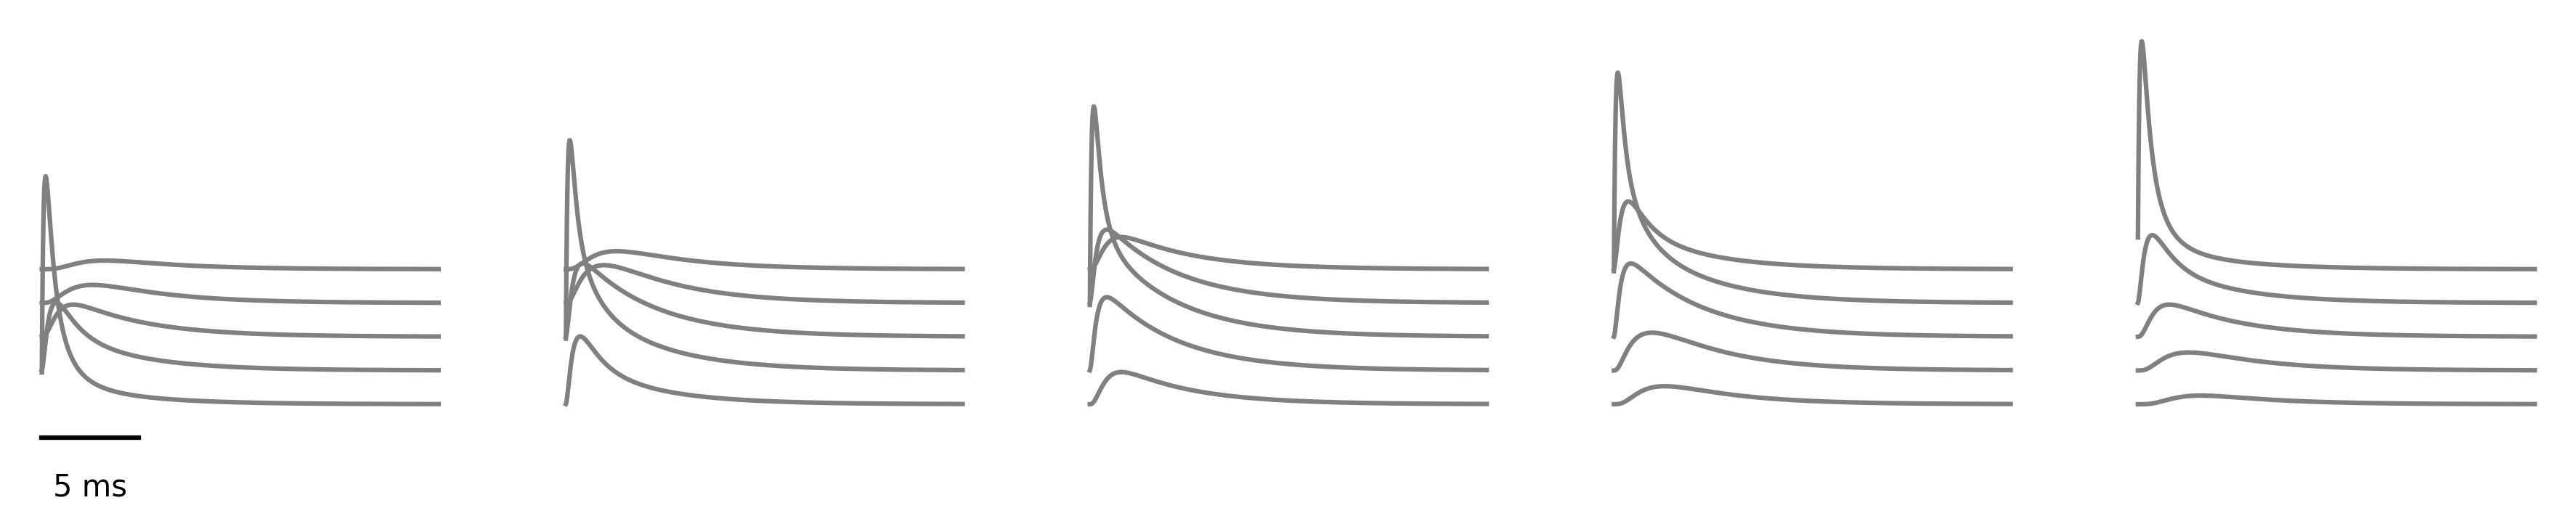

In [4]:


fig, ax = plt.subplots(
    1,
    5,
    sharex=True,
    figsize=(3 * 5, 3 * 5),
    sharey=True,
    subplot_kw=dict(box_aspect=1),
    dpi=300,
)
for idx in range(N):
    for site in range(5):
        ax[site].plot(time, actual_v[idx][:, site] + 0.01 * idx, color="grey")
        ax[site].set_axis_off()

ax[0].plot([0, 5], [-0.01, -0.01], color="black")
ax[0].text(2.5, -0.02, "5 ms", ha="center", va="top")

plt.savefig("passive_cable.png", bbox_inches="tight")

In [5]:
import numpy as onp
import jax


@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitCDE):
    d: ArrayLike
    u: ArrayLike
    p: ArrayLike

    def explicit_terms(self, state, u):
        return NeuronState(v=state.I, I=-20 * state.I + u.I)

    def implicit_terms(self, state):
        return NeuronState(
            v=tree_matmul(self.d, self.u, self.p, state.v), I=np.zeros_like(state.I)
        )

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )


@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike


def input_integrator(stim):
    N = 5
    dt = 1e-2
    inner_steps = 1
    outer_steps = 2048
    time = dt * inner_steps * (1 + np.arange(outer_steps))
    equation = MultiCompartmentNeuronModel(
        d=-2 * np.ones(N), u=np.ones(N - 1), p=np.arange(-1, N, 1)
    )

    semi_implicit_step = implicit.imex_rk_sil3_cde(equation, dt)
    integrator = funcutils.controlled_trajectory(semi_implicit_step, stim)
    initial_state = NeuronState(v=np.zeros(N), I=np.zeros(N))
    _, actual = integrator(initial_state)
    return actual.v[-1][-1]


T = 2048
dt = 0.1
stim = onp.zeros((T, 1))
stim[0, 0] = 1.0
time = dt * (1 + np.arange(T))

stim = NeuronState(v=np.zeros((T, 5)), I=np.zeros((T, 5)))

fn = jax.value_and_grad(input_integrator)
out, grad = fn(stim)

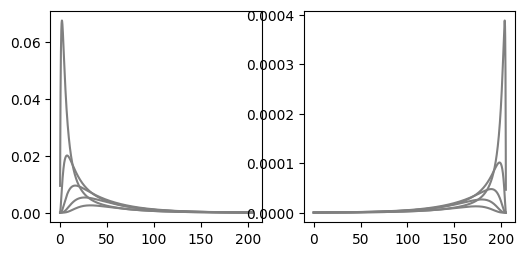

In [6]:
fig, ax = plt.subplots(
    1,
    2,
    sharex=True,
    figsize=(3 * 2, 3 * 2),
    subplot_kw=dict(box_aspect=1),
)

for i in range(5):
    ax[1].plot(time, grad.I[:, i], color="grey")

for i in range(5):
    ax[0].plot(time, actual_v[-1][:, i], color="grey")


plt.savefig("passive_cable.png", bbox_inches="tight")

In [7]:
a = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
    ]
)
b = np.arange(1, 9)
parents = np.matmul(a, b)

In [8]:
np.diag(np.sum(a + a.T, axis=0)) - (a + a.T)

Array([[ 1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  3, -1,  0,  0, -1,  0,  0],
       [ 0, -1,  3, -1, -1,  0,  0,  0],
       [ 0,  0, -1,  1,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  3, -1, -1],
       [ 0,  0,  0,  0,  0, -1,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1]], dtype=int32)

In [9]:
@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
    m: ArrayLike

    def explicit_terms(self, state):
        return NeuronState(v=state.I, I=-20 * state.I)

    def implicit_terms(self, state):
        return NeuronState(v=np.matmul(self.m, state.v), I=np.zeros_like(state.I))

    def implicit_solve(self, state, step_size):
        return NeuronState(
            v=tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
            I=state.I,
        )

In [10]:
def coupling_matrix(G_m, D_s, G_a, A, D_i):
    """ "
    Parameters:
        G_m: membrane conductance
        G_a: axial conductance
        D_s: diagonal matrix of compartment surfaces
        D_i: diagonal matrix of inverse volumes
        A  : adjacency matrix
    """
    m = np.matmul(A, D_i) + np.matmul(D_i, A.T)
    M = G_a * (np.diag(np.sum(m)) - m) + G_m * D_s
    return M

Instead of involving the geometry of the neuron (such as the surface and inverse volumes) we can instead use abstract conductances. This simplifies the implementation of the coupling matrix to

In [11]:
def coupling_matrix(G, G_m):
    """ "
    Parameters:
        G   : coupling conductances
        G_m : membrane coupling conductances (typically dynamic)
    """
    m = G + G.T
    laplace = np.diag(np.sum(m, axis=0)) - m
    return laplace + np.diag(G_m)

Branching chain with four compartments in each chain